In [ ]:
!pip install pandas
!pip install numpy==1.23

In [ ]:
!pip install tensorflow==2.12
!pip install pyarabic

In [ ]:
!pip install transformers

In [ ]:
!pip install ipywidgets
!pip install datasets
!pip install transformers[torch]
!pip install nvidia-ml-py3

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 


import numpy as np
import tensorflow as tf
import pandas as pd
import pyarabic.araby as araby
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)

2023-07-28 03:24:20.129334: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 03:24:20.149442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 03:24:20.486564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# cell-1  
#load and clean the data (removing diacritics and unwanted text)

df = pd.read_csv('poemsDataset.csv')
df.fillna('', inplace=True)
display(len(df))


def remove_diacritics(a):    
    return araby.strip_diacritics(a)

df['first_hemistich'] = df['first_hemistich'].apply(remove_diacritics)
df['second_hemistich'] = df['second_hemistich'].apply(remove_diacritics)

def normalizeBeforeTraining(df):
    df['first_hemistich'] = df['first_hemistich'].str.replace('النابغـة: ', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('الـربيع: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('عبيــد: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امـرؤ القيسـ: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امرؤ القيس: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(جلال الــــدين الــــرومي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(لـوك الفيلسـوف الإنكليزي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(كانت الفيلسوف الألماني ):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(بركســــــــــــــــون):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الحـــــــــــــــور):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الشــــــــــــــاعر):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الإنســـــــــــــــان):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('العلم):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(العشــــــــــــــــق):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الزهــــــــــــــــــرة):', '', regex=False)
    df['second_hemistich'] = df['second_hemistich'].str.replace('التوأم اليشكري: ', '', regex=False)  
    df['first_hemistich'] = df['first_hemistich'].str.replace('آ', 'أ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('آ', 'أ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('[/":?،؟]', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('[/":?،؟]', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')


normalizeBeforeTraining(df)
df.drop(df[(df['first_hemistich'] == '') & (df['second_hemistich'] == '')].index, inplace=True)

#if first_hemistich == '', then copy the text from second_hemistich. then delete the text in the second_hemistich
df['first_hemistich'] = df.apply(lambda x: x['second_hemistich'] if x['first_hemistich'] == '' else x['first_hemistich'], axis=1)
df['second_hemistich'] = df.apply(lambda x: '' if x['first_hemistich'] == x['second_hemistich'] else x['second_hemistich'], axis=1)

df.reset_index(drop=True, inplace=True)

display(len(df))
# display(df[:10])
print('done')

2090907

2090907

done


In [10]:
#number of male and female poets in the dataset
dff = df[['poet', 'gender']]
print(len(dff))
dff = dff.drop_duplicates()
print(len(dff))
dx = dff.groupby(['gender']).count()
dx

2090907
5384


,poet
gender,
,1
f,360
m,5023


In [3]:
# cell-2 
# preparing data for finetuning


df['second_hemistich'].replace('', 'E', inplace=True)
dfc = df[['first_hemistich', 'second_hemistich', 'gender']].copy()
dfc['text'] = dfc['first_hemistich'] + ' S ' + dfc['second_hemistich']

#removing verses without a gender
dfc = dfc[dfc['gender'] != ''] 



dfc.reset_index(drop=True, inplace=True)


dfc['gender'] = dfc['gender'].astype('category')

dfc['label'] = dfc['gender'].cat.codes 
dftrain, dftest = train_test_split(dfc, test_size=0.20, random_state=42, stratify=dfc['label'])
ytrain = dftrain['label'].values.tolist()
ytest = dftest['label'].values.tolist()



max_sequence_length = 32
train_batch_size = 256
classes_num = len(dfc['gender'].unique())

display(classes_num)
display(len(dfc))
display(len(dftrain))
display(len(dftest))

2

2087557

1670045

417512

In [4]:
#cell-3
#loading the tokenizer and the model

from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('faisalq/bert-base-arapoembert')
model = BertForSequenceClassification.from_pretrained('faisalq/bert-base-arapoembert',
                                                      num_labels=classes_num).to('cuda')                                        


Some weights of the model checkpoint at faisalq/bert-base-arapoembert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at faisalq/bert-ba

In [5]:
#cell-4
#tokenizing the data

xtrain = tokenizer(
    text=dftrain['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='pt',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


xtest = tokenizer(
    text=dftest['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='pt',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [7]:
# display(xtest)
display(xtest['input_ids'][0])

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    2,  2914,   277,   151,  2890,  1110,    83, 31553,  8365,
           9, 25033,   122,    85,  4147,  5444,   678,   321, 40125,
           3,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)>

In [6]:
#group text and labels and create train_ds and test_ds

import torch

class NewGroupDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['label'] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_ds = NewGroupDataset(xtrain, ytrain)
test_ds = NewGroupDataset(xtest, ytest)

from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return { 'accuracy': acc }

In [7]:
from transformers import Trainer, TrainingArguments


epochs = 1
save_steps = 10000 #save checkpoint every 10000 steps
batch_size = 256

training_args = TrainingArguments(
    output_dir = 'araPoemBERT_base_gender/',
    overwrite_output_dir=True,
    num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps = save_steps,
    save_total_limit = 5, #only save the last 5 checkpoints
    fp16=True,
    learning_rate = 5e-5,  # 5e-5 is the default
    logging_steps = 1000, #50_000
    evaluation_strategy = 'steps',
    # evaluate_during_training = True,
    eval_steps = 1000
    
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics = compute_metrics
)


# trainer.train(resume_from_checkpoint=True)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,0.038900,0.036060,0.992817
2000,0.036400,0.033963,0.993097
3000,0.033800,0.032768,0.993248
4000,0.033500,0.032444,0.993138
5000,0.032500,0.031529,0.993389
6000,0.031800,0.031168,0.993409


TrainOutput(global_step=6524, training_loss=0.03430077782589405, metrics={'train_runtime': 500.6762, 'train_samples_per_second': 3335.579, 'train_steps_per_second': 13.03, 'total_flos': 2.291752336845504e+16, 'train_loss': 0.03430077782589405, 'epoch': 1.0})

In [12]:
trainer.save_model('araPoemBERT_base_gender/')

In [8]:
p = trainer.predict(test_ds)

In [11]:
p

PredictionOutput(predictions=array([[-2.8183594,  2.6582031],
       [-3.6640625,  3.5976562],
       [-3.90625  ,  4.0078125],
       ...,
       [-3.6757812,  3.7128906],
       [-4.       ,  4.0390625],
       [-3.1269531,  3.0488281]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.030866090208292007, 'test_accuracy': 0.9934684512061929, 'test_runtime': 25.1641, 'test_samples_per_second': 16591.543, 'test_steps_per_second': 64.814})

In [9]:
y_pred = np.argmax(p[0], axis = 1)

print(classification_report(ytest, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7582    0.1318    0.2246      2996
           1     0.9938    0.9997    0.9967    414516

    accuracy                         0.9935    417512
   macro avg     0.8760    0.5658    0.6107    417512
weighted avg     0.9921    0.9935    0.9912    417512



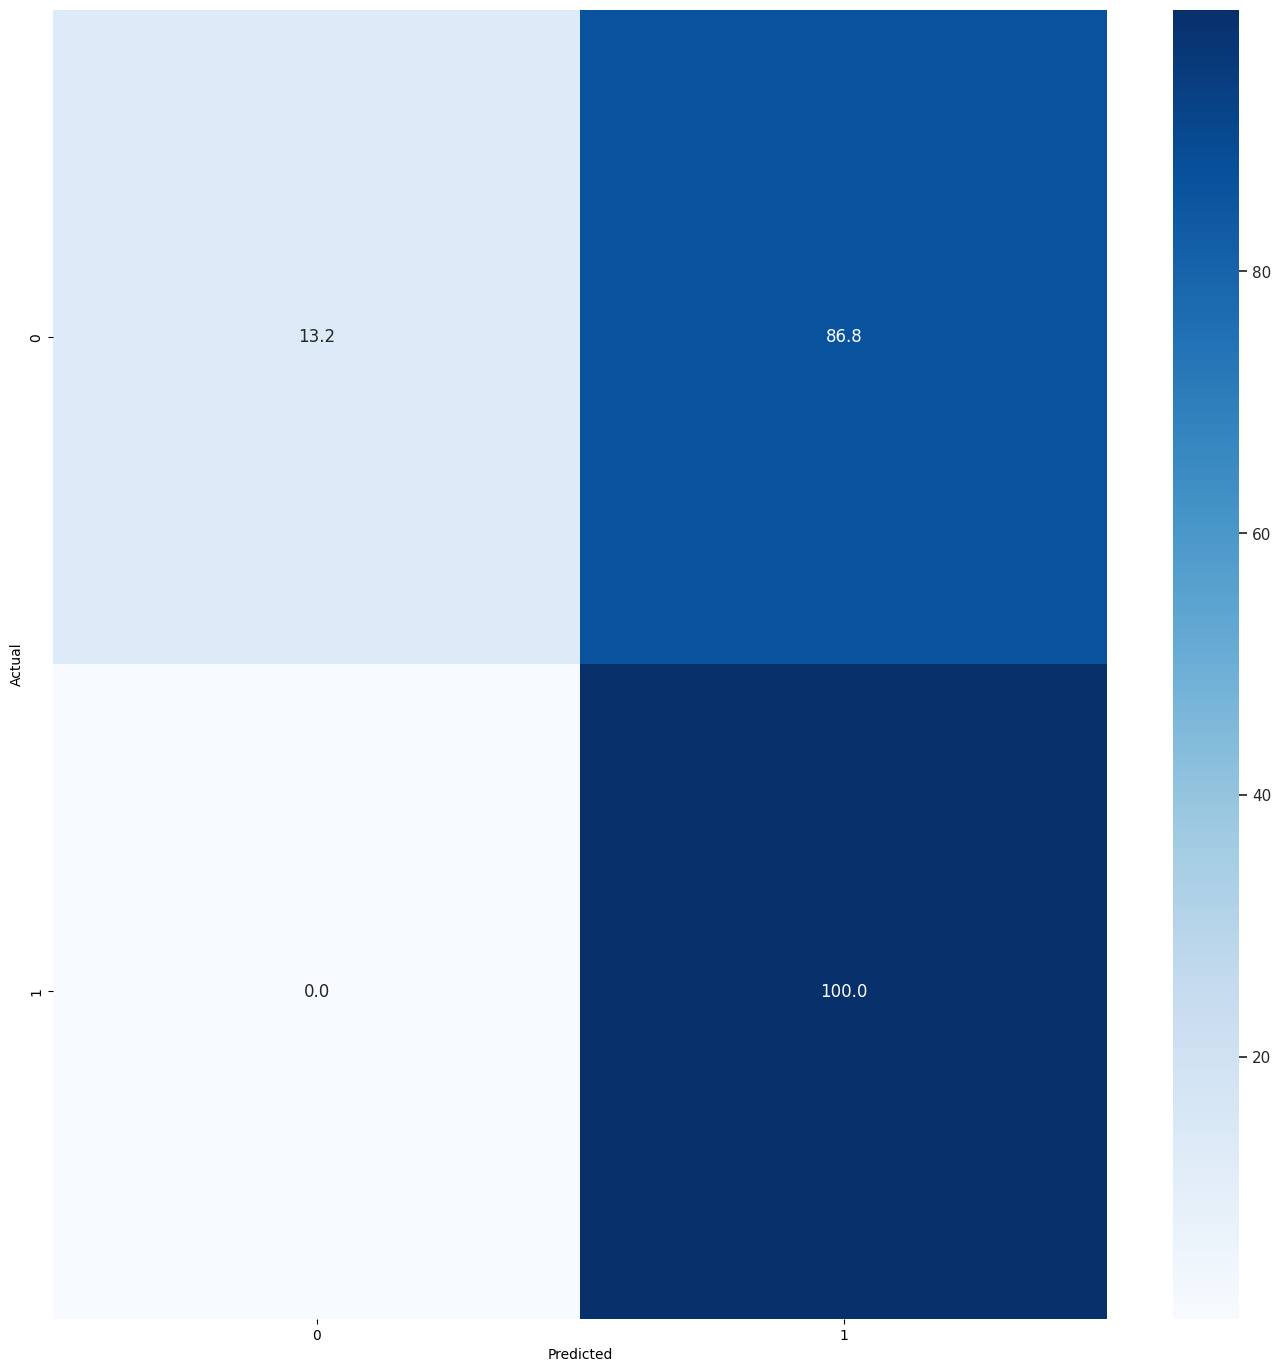

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn, numpy as np
import matplotlib.pyplot as plt

matrix = confusion_matrix(ytest, y_pred)
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
cmn = cmn*100
fig, ax = plt.subplots(figsize=(17,17))
sn.set(font_scale=1)
sn.heatmap(cmn, annot=True, fmt='.1f', xticklabels=range(classes_num), yticklabels=range(classes_num), cmap="Blues",
          annot_kws={"size": 12})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('gender_cm.png')
plt.show(block=False)